# Car Rental Demand Forecast

Group: 
- Amal V Nair
- Abul Hassan
- Shahal K
- Sulala Saleem


## Importing Relevant Libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [ ]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

## Reading Dataset Into Python

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Ml_course/Data/car_demand.csv')
df.head()

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [ ]:
df.shape

(18247, 3)

## Data Analysis and Exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  int64 
 2   demand  18247 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.8+ KB


In [ ]:
df.describe()

,hour,demand
count,18247.000000,18247.000000
mean,12.614731,73.991451
std,6.544963,41.678988
min,0.000000,1.000000
25%,8.000000,43.000000
50%,13.000000,71.000000
75%,18.000000,98.000000
max,23.000000,379.000000


In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.dtypes

date      datetime64[ns]
hour               int64
demand             int64
dtype: object

In [ ]:
df['date'].describe(datetime_is_numeric=True)

count                            18247
mean     2019-11-22 18:35:10.637365248
min                2018-08-18 00:00:00
25%                2019-04-09 00:00:00
50%                2019-11-29 00:00:00
75%                2020-06-29 00:00:00
max                2021-02-28 00:00:00
Name: date, dtype: object

Data ranges from 2018-08-18 to 2021-02-28 on an hourly basis

In [ ]:
df.isnull().sum()

date      0
hour      0
demand    0
dtype: int64

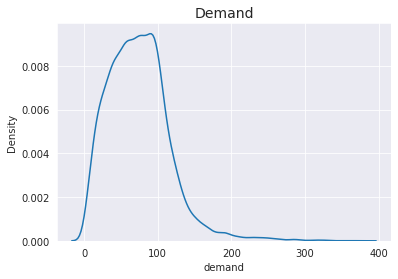

In [ ]:
sns.set_style('darkgrid')
sns.kdeplot(x=df['demand'])
plt.title('Demand', fontsize=14)
plt.show()

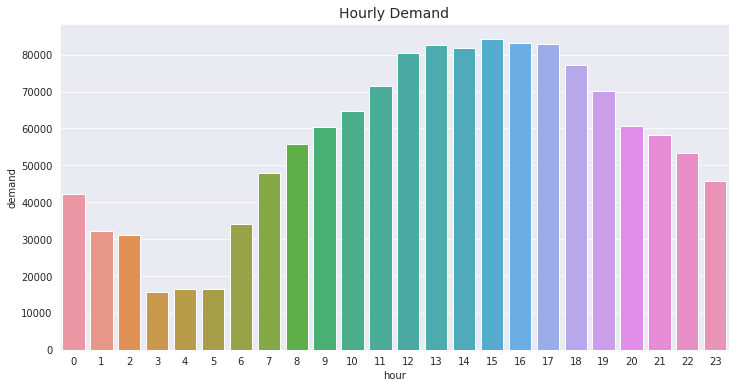

In [ ]:
hourly_demand = df.groupby('hour')['demand'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_demand['hour'][::-1], y='demand', data=hourly_demand)
plt.title('Hourly Demand', fontsize=14)
plt.show()

Data clearly has a trend of rising demand towards afternoon and evening hours and falling towards late night:early morning.

### Extracting more features

In [ ]:
df['day'] = df['date'].apply(lambda x: x.day)
df['month'] = df['date'].apply(lambda x: x.month)
df['year'] = df['date'].apply(lambda x: x.year)

In [ ]:
df['day_of_week'] = df['date'].apply(lambda x: x.dayofweek)
df['quarter_of_year'] = df['date'].apply(lambda x: x.quarter)

In [ ]:
df['is_weekend'] = df['day_of_week'].apply(lambda x: 0 if x < 5 else 1)

In [ ]:
df.head()

,date,hour,demand,day,month,year,day_of_week,quarter_of_year,is_weekend
0,2018-08-18,9,91,18,8,2018,5,3,1
1,2018-08-18,10,21,18,8,2018,5,3,1
2,2018-08-18,13,23,18,8,2018,5,3,1
3,2018-08-18,14,104,18,8,2018,5,3,1
4,2018-08-18,15,81,18,8,2018,5,3,1


### Demand by Day of Week

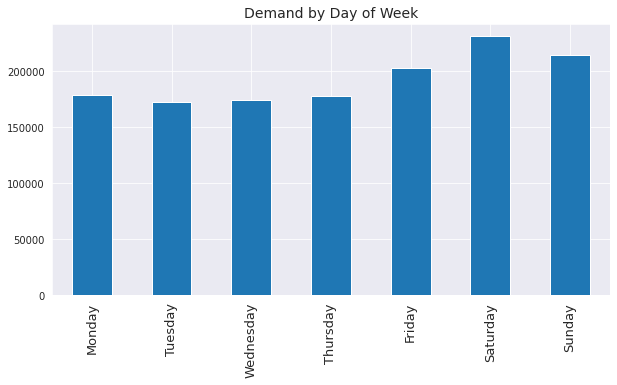

In [ ]:
df.groupby('day_of_week')['demand'].sum().plot(kind='bar', figsize=(10, 5))
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], 
           labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
           fontsize=13)
plt.xlabel('')
plt.title('Demand by Day of Week', fontsize=14)
plt.show()

There seems to be a rise in demand towards weekend.

### Demand by Month each year

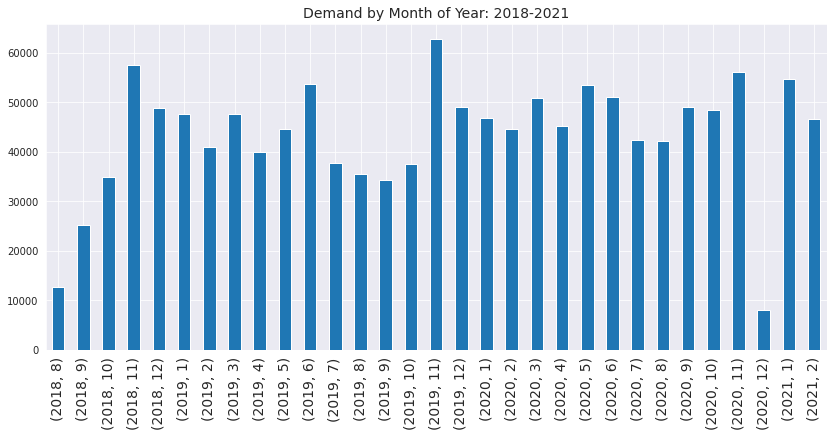

In [ ]:
df.groupby(['year', 'month'])['demand'].sum().plot(kind='bar', figsize=(14, 6))
plt.xticks(fontsize=14)
plt.xlabel('')
plt.title('Demand by Month of Year: 2018-2021', fontsize=14)
plt.show()

- November every year seems to have the highest business perhaps due to coming holiday season.
- There was a general slump in 2020
- Business seems to be picking up in 2021

### Demand by Quarterly Period

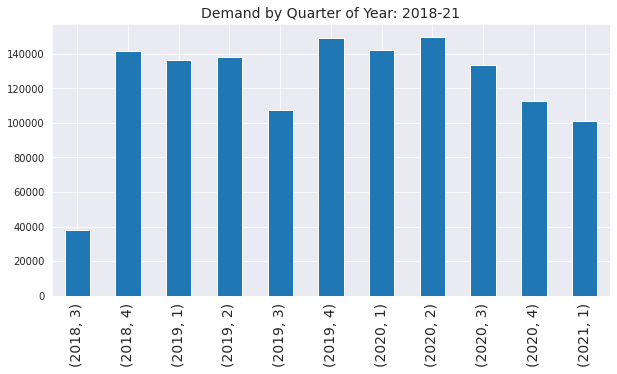

In [ ]:
df.groupby(['year', 'quarter_of_year'])['demand'].sum().plot(kind='bar', figsize=(10, 5))
plt.xticks(fontsize=14)
plt.xlabel('')
plt.title('Demand by Quarter of Year: 2018-21', fontsize=14)
plt.show()

### Extracting more features

In [ ]:
def time_of_day(n):
    if n in range(4,8):
        return 'Early Morning'
    elif n in range(8,12):
        return 'Morning'
    elif n in range(12,18):
        return 'Afternoon'
    elif n in range(18,21):
        return 'Evening'
    elif n in range(21,25) or n==0:
        return 'Night'
    elif n in range(1,4):
        return 'Late Night'

In [ ]:
df['time_of_day'] = df['hour'].apply(time_of_day)

In [ ]:
def seasons(x):
    if x in [9, 10, 11]:
        season = 'Spring'
    elif x in [12, 1, 2]:
        season = 'Summer'
    elif x in [3, 4, 5]:
        season = 'Autumn'
    elif x in [6, 7, 8]:
        season = 'Winter'
    return season

In [ ]:
df['season'] = df['month'].apply(seasons)

In [ ]:
df.head()

,date,hour,demand,day,month,year,day_of_week,quarter_of_year,is_weekend,time_of_day,season
0,2018-08-18,9,91,18,8,2018,5,3,1,Morning,Winter
1,2018-08-18,10,21,18,8,2018,5,3,1,Morning,Winter
2,2018-08-18,13,23,18,8,2018,5,3,1,Afternoon,Winter
3,2018-08-18,14,104,18,8,2018,5,3,1,Afternoon,Winter
4,2018-08-18,15,81,18,8,2018,5,3,1,Afternoon,Winter


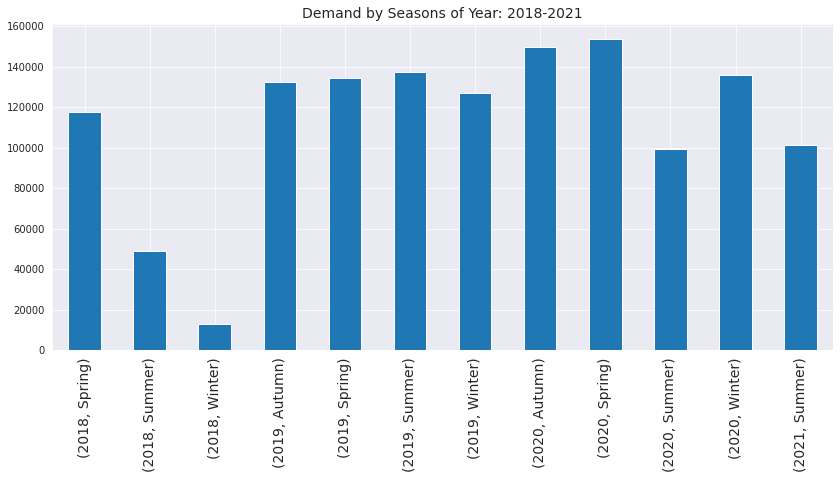

In [ ]:
df.groupby(['year', 'season'])['demand'].sum().plot(kind='bar', figsize=(14, 6))
plt.xticks(fontsize=14)
plt.xlabel('')
plt.title('Demand by Seasons of Year: 2018-2021', fontsize=14)
plt.show()

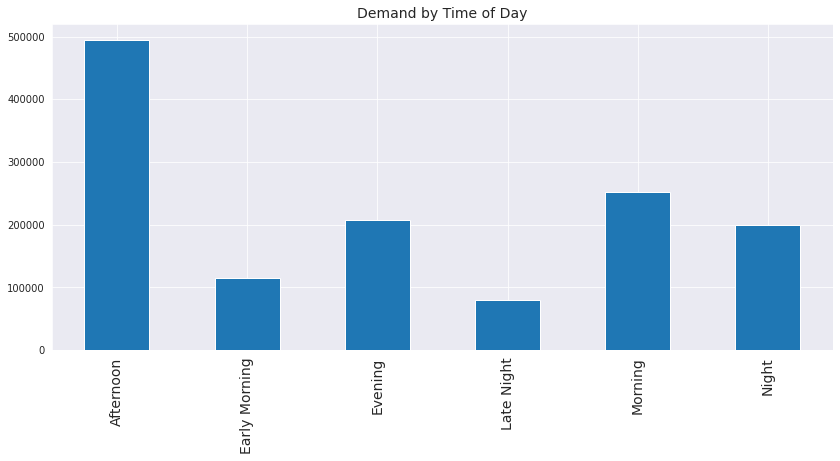

In [ ]:
df.groupby('time_of_day')['demand'].sum().plot(kind='bar', figsize=(14, 6))
plt.xticks(fontsize=14)
plt.xlabel('')
plt.title('Demand by Time of Day', fontsize=14)
plt.show()

Working hours seem to have most demand

In [ ]:
df.head()

,date,hour,demand,day,month,year,day_of_week,quarter_of_year,is_weekend,time_of_day,season
0,2018-08-18,9,91,18,8,2018,5,3,1,Morning,Winter
1,2018-08-18,10,21,18,8,2018,5,3,1,Morning,Winter
2,2018-08-18,13,23,18,8,2018,5,3,1,Afternoon,Winter
3,2018-08-18,14,104,18,8,2018,5,3,1,Afternoon,Winter
4,2018-08-18,15,81,18,8,2018,5,3,1,Afternoon,Winter


## Preprocessing

In [ ]:
X = df.drop(['date', 'demand'], axis=1)
y = df['demand']

### Cyclical Features

Since several features like hour, month etc. are cyclical, we can convert them first into a period of $ 2\pi $ and then into co-ordinates of sin and cos to capture the cyclic nature.

In [ ]:
def pi_period(x, max_period):
    x = 2 * (np.pi * x) / max_period
    return x

In [ ]:
X['hour'] = X['hour'].apply(lambda x: pi_period(x, X['hour'].max()))

In [ ]:
X['day'] = X['day'].apply(lambda x: pi_period(x, X['day'].max()))

In [ ]:
X['month'] = X['month'].apply(lambda x: pi_period(x, X['day'].max()))

In [ ]:
X.head()

,hour,day,month,year,day_of_week,quarter_of_year,is_weekend,time_of_day,season
0,2.458638,3.648301,8.0,2018,5,3,1,Morning,Winter
1,2.731820,3.648301,8.0,2018,5,3,1,Morning,Winter
2,3.551366,3.648301,8.0,2018,5,3,1,Afternoon,Winter
3,3.824548,3.648301,8.0,2018,5,3,1,Afternoon,Winter
4,4.097730,3.648301,8.0,2018,5,3,1,Afternoon,Winter


In [ ]:
X['hour_cos'] = np.cos(X['hour'])
X['hour_sin'] = np.sin(X['hour'])

In [ ]:
X['day_cos'] = np.cos(X['day'])
X['day_sin'] = np.sin(X['day'])

In [ ]:
X['month_cos'] = np.cos(X['month'])
X['month_sin'] = np.sin(X['month'])

In [ ]:
X.head()

,hour,day,month,year,day_of_week,quarter_of_year,is_weekend,time_of_day,season,hour_cos,hour_sin,day_cos,day_sin,month_cos,month_sin
0,2.458638,3.648301,8.0,2018,5,3,1,Morning,Winter,-0.775711,0.631088,-0.874347,-0.485302,-0.1455,0.989358
1,2.731820,3.648301,8.0,2018,5,3,1,Morning,Winter,-0.917211,0.398401,-0.874347,-0.485302,-0.1455,0.989358
2,3.551366,3.648301,8.0,2018,5,3,1,Afternoon,Winter,-0.917211,-0.398401,-0.874347,-0.485302,-0.1455,0.989358
3,3.824548,3.648301,8.0,2018,5,3,1,Afternoon,Winter,-0.775711,-0.631088,-0.874347,-0.485302,-0.1455,0.989358
4,4.097730,3.648301,8.0,2018,5,3,1,Afternoon,Winter,-0.576680,-0.816970,-0.874347,-0.485302,-0.1455,0.989358


In [ ]:
X.drop(['hour', 'day', 'month'], axis=1, inplace=True)
X.head()

,year,day_of_week,quarter_of_year,is_weekend,time_of_day,season,hour_cos,hour_sin,day_cos,day_sin,month_cos,month_sin
0,2018,5,3,1,Morning,Winter,-0.775711,0.631088,-0.874347,-0.485302,-0.1455,0.989358
1,2018,5,3,1,Morning,Winter,-0.917211,0.398401,-0.874347,-0.485302,-0.1455,0.989358
2,2018,5,3,1,Afternoon,Winter,-0.917211,-0.398401,-0.874347,-0.485302,-0.1455,0.989358
3,2018,5,3,1,Afternoon,Winter,-0.775711,-0.631088,-0.874347,-0.485302,-0.1455,0.989358
4,2018,5,3,1,Afternoon,Winter,-0.576680,-0.816970,-0.874347,-0.485302,-0.1455,0.989358


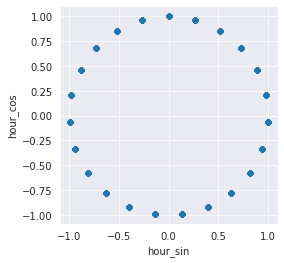

In [ ]:
X.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')

### VIF SCORE:
Variance Inflation factor helps measure multicollinearity of features.

In [ ]:
num_cols = X.select_dtypes(exclude='object').columns.to_list()

In [ ]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X[num_cols].values, i) for i in range(X[num_cols].shape[1])]
vif_info['Columns'] = X[num_cols].columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Columns
0,10.432352,year
1,8.748351,day_of_week
2,7.489910,quarter_of_year
3,3.758936,is_weekend
9,1.340496,month_sin
5,1.037327,hour_sin
4,1.015839,hour_cos
8,1.013451,month_cos
6,1.002107,day_cos
7,1.000391,day_sin


In [ ]:
X.drop('year', axis=1, inplace=True)

In [ ]:
X.head()

,day_of_week,quarter_of_year,is_weekend,time_of_day,season,hour_cos,hour_sin,day_cos,day_sin,month_cos,month_sin
0,5,3,1,Morning,Winter,-0.775711,0.631088,-0.874347,-0.485302,-0.1455,0.989358
1,5,3,1,Morning,Winter,-0.917211,0.398401,-0.874347,-0.485302,-0.1455,0.989358
2,5,3,1,Afternoon,Winter,-0.917211,-0.398401,-0.874347,-0.485302,-0.1455,0.989358
3,5,3,1,Afternoon,Winter,-0.775711,-0.631088,-0.874347,-0.485302,-0.1455,0.989358
4,5,3,1,Afternoon,Winter,-0.576680,-0.816970,-0.874347,-0.485302,-0.1455,0.989358


In [ ]:
num_cols = X.select_dtypes(exclude='object').columns.to_list()
vif_after = pd.DataFrame()
vif_after['VIF'] = [variance_inflation_factor(X[num_cols].values, i) for i in range(X[num_cols].shape[1])]
vif_after['Columns'] = X[num_cols].columns
vif_after.sort_values('VIF', ascending=False)

,VIF,Columns
0,6.418026,day_of_week
2,3.461693,is_weekend
1,2.980924,quarter_of_year
8,1.130890,month_sin
4,1.036579,hour_sin
3,1.015753,hour_cos
7,1.011339,month_cos
5,1.001824,day_cos
6,1.000362,day_sin


### Encoding

In [ ]:
X = pd.get_dummies(columns=['time_of_day', 'season'], data=X, drop_first=True)

In [ ]:
X.head(3)

,day_of_week,quarter_of_year,is_weekend,hour_cos,hour_sin,day_cos,day_sin,month_cos,month_sin,time_of_day_Early Morning,time_of_day_Evening,time_of_day_Late Night,time_of_day_Morning,time_of_day_Night,season_Spring,season_Summer,season_Winter
0,5,3,1,-0.775711,0.631088,-0.874347,-0.485302,-0.1455,0.989358,0,0,0,1,0,0,0,1
1,5,3,1,-0.917211,0.398401,-0.874347,-0.485302,-0.1455,0.989358,0,0,0,1,0,0,0,1
2,5,3,1,-0.917211,-0.398401,-0.874347,-0.485302,-0.1455,0.989358,0,0,0,0,0,0,0,1


## Model Evaluation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def model_eval(alg, train_x=X_train, train_y=y_train, test_x=X_test, test_y=y_test):
    model = alg.fit(train_x, train_y)
    model_pred = model.predict(test_x)
    model_rmse = mean_squared_error(test_y, model_pred, squared=False)
    model_r2 = r2_score(test_y, model_pred)
    print(f"The evaluation scores of model {type(rfr).__name__}: ")
    print(f"\nRoot mean squared error is: {model_rmse}")
    print(f"\nR-squared value is: {model_r2}")

In [ ]:
rfr = RandomForestRegressor()
model_eval(rfr)

The evaluation scores of model RandomForestRegressor: 

Root mean squared error is: 34.12535530251014

R-squared value is: 0.30069148223554787


In [ ]:
abr = AdaBoostRegressor()
model_eval(abr)

The evaluation scores of model RandomForestRegressor: 

Root mean squared error is: 36.20255403156105

R-squared value is: 0.2129671219606062


In [ ]:
gbr = GradientBoostingRegressor()
model_eval(gbr)

The evaluation scores of model RandomForestRegressor: 

Root mean squared error is: 34.060827658723895

R-squared value is: 0.3033336271948166


Gradient Boosting gives best result